In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
# import pyecharts

In [2]:
def loadDataSet(fileName):
    numFeat = len(open(fileName).readline().strip().split('\t')) -1
    xArr = []
    yArr = []
    with open(fileName) as fr:
        for line in fr.readlines():
            currntLine = line.strip().split('\t')
            arr = []
            for i in range(numFeat):
                arr.append(float(currntLine[i]))
            xArr.append(arr)
            yArr.append(float(currntLine[-1])) # 列向量
    return xArr,yArr

def loadDataMat(fileName):
    text = np.loadtxt("./abalone.txt")
    xMat = np.mat(text[:,:-1],dtype=np.float)
    yMat = np.mat(text[:,-1],dtype=np.float).T # 列向量
    return xMat,yMat



In [3]:
xArr,yArr = loadDataSet("./abalone.txt")

In [4]:
xMat,yMat = loadDataMat("./abalone.txt")

# ridge regression 领回归

In [ ]:
# 解决数据量少于特征维度导致 xTx 不满秩无法求解逆的情况
# 引入了偏差 ？大概是因为lambda*I 中的项除了xTx为零的行中，也会添加到非零的行中，但是这样不是导致不同特征的偏差一致？
# 实现： x.T * x + lambda*I  lambda 是实数，I是单位矩阵
# lambda 通过多次遍历寻找使误差最小的最优解
# 需要归一化，这与lambda遍历的取值有关（0，1）

In [5]:
def ridgeRegress(xMat,yMat,lam = 0.2):
    xTx = xMat.T * xMat
    denom = xTx + lam*np.mat(np.eye(np.shape(xMat)[1]))
    if np.linalg.det(denom) == 0.0:
        return '行列式为0'
    ws =denom.I * (xMat.T*yMat)
    return ws

In [6]:
def ridgeTest(xArr,yArr):
    xMat = np.mat(xArr)
    yMat = np.mat(yArr).T
    xMean = np.mean(xMat,0) # 压缩成一个行
    yMean = np.mean(yMat,0) 
    xVar = np.var(xMat,0) # 方差
    yVar = np.var(yMat,0)
    xMat = (xMat - xMean)/xVar  # 为什么一个是归一化，一个没有彻底归一化？？？？
    yMat = yMat - yMean
    numTestPts = 30 # 尝试的次数
    wMat = np.mat(np.zeros((numTestPts,np.shape(xMat)[1])))
    for i in range(numTestPts):
        ws = ridgeRegress(xMat,yMat,np.exp(i-10)) #指数衰减，为了lambda变化更加剧烈
        wMat[i,:] = ws.T
    return wMat

In [58]:
def ressError(yHat,yMat):
    return ((yMat.T.A[0]-yHat.T.A[0])**2).sum()

In [117]:
# 30个不同lambda的回归系数
ridgeWeights = ridgeTest(xArr,yArr)

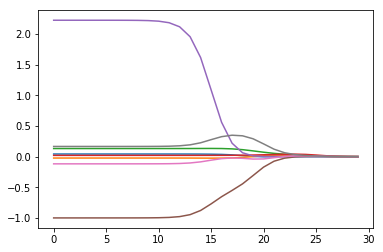

In [66]:
# lambda 较小时，ws保持原有值，lambda最大时，ws全部收敛到0
# 通过遍历不同lambda下的误差函数求最优lambda
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(ridgeWeights)
plt.show()

In [68]:
# 从不同lambda中挑选误差最小的最优解
def bestRidge(xArr,yArr,ridgeWeights):
    xMat = np.mat(xArr)
    yMat = np.mat(yArr).T
    xMean = np.mean(xMat,0) # 压缩成一个行
    yMean = np.mean(yMat,0) 
    xVar = np.var(xMat,0) # 方差
    yVar = np.var(yMat,0)
    xMat = (xMat - xMean)/xVar  # 为什么一个是归一化，一个没有彻底归一化？？？？
    yMat = yMat - yMean
    numTestPts = np.shape(ridgeWeights)[0] # 尝试的次数
    yHat = np.mat(np.zeros((numTestPts ,np.shape(yMat)[0])))# 预测结果矩阵
    errors = np.zeros((numTestPts,1))
    lowestIndex = 0
    lowestLambda = 0
    lowestError = np.inf
    for i in range(numTestPts):
        yHat[i,:] = (xMat*ridgeWeights[i,:].T).T
        errors[i,:] = ressError(yHat[i,:].T,yMat)
        if errors[i,:] < lowestError:
            lowestError = errors[i,:]
            lowestLambda = ridgeWeights[i,:]
            lowestIndex = i
        print(errors[i,:])
    return lowestError,lowestLambda,ridgeWeights[lowestIndex,:]

[ 20494.55218986]
[ 20494.55218986]
[ 20494.55218986]
[ 20494.55218989]
[ 20494.55219008]
[ 20494.55219152]
[ 20494.55220212]
[ 20494.55228044]
[ 20494.55285844]
[ 20494.5571149]
[ 20494.58827956]
[ 20494.81293694]
[ 20496.36703624]
[ 20506.04803989]
[ 20553.40864041]
[ 20700.08222636]
[ 20941.89989275]
[ 21179.47710157]
[ 21473.69077461]
[ 22184.83175692]
[ 23668.29337342]
[ 25587.26188186]
[ 27140.68123588]
[ 28169.04231816]
[ 29386.15102311]
[ 32084.60763709]
[ 36317.05826729]
[ 39966.62318889]
[ 41981.9205655]
[ 42859.6064519]


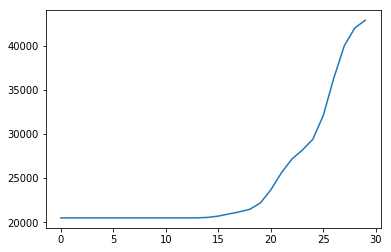

In [119]:
# 这个结果有些尴尬，不过训练集数量远大于特征数量，所以
lowestError,lowestLambda,Weights = bestRidge(xArr,yArr,ridgeWeights)
errorFig = plt.figure()
errorAx = errorFig.add_subplot(111)
errorAx.plot(arr)
plt.show()

# step regression 逐步回归

# Forward-Stagewise Regression 前向分段 逐步回归

In [63]:
def stageWise(xArr,yArr,eps = 0.01,numIt = 100):
    xMat = np.mat(xArr)
    yMat = np.mat(yArr).T
    xMean = np.mean(xArr,0)
    yMean = np.mean(yArr,0)
    xVar = np.var(xArr,0)
    xMat = (xMat-xMean)/xVar
    yMat = yMat - yMean
    m,n = np.shape(xMat)
    retWetMat = np.zeros((numIt,n))
    ws = np.zeros((n,1))
    wsTest = ws.copy()
    wsMax = ws.copy()
    for i in range(numIt):
        print(ws.T)
        lowestError = np.inf
        for j in range(n):
            for sign in [-1,1]: # 对于加减的特殊写法
                wsTest = ws.copy()
                wsTest[j] += eps*sign         #   加或者减一个很小的偏差
                yTest = xMat * wsTest
                rssE = ressError(yTest,yMat)
                if rssE < lowestError:
                    lowestError = rssE
                    wsMax = wsTest
        ws = wsMax.copy()
        retWetMat[i,:] = ws.T
    return retWetMat         

In [70]:
# 分析输出结果：
# w1 w6 始终为0，这是无关特征
# 系数在后期已经饱和，在一定值范围内波动，这是步长太大的缘故
retWetMat  = stageWise(xArr,yArr,0.01,200)
retWetMat

[[ 0.  0.  0.  0.  0.  0.  0.  0.]]
[[ 0.    0.    0.    0.01  0.    0.    0.    0.  ]]
[[ 0.    0.    0.    0.02  0.    0.    0.    0.  ]]
[[ 0.    0.    0.    0.03  0.    0.    0.    0.  ]]
[[ 0.    0.    0.    0.04  0.    0.    0.    0.  ]]
[[ 0.    0.    0.    0.05  0.    0.    0.    0.  ]]
[[ 0.    0.    0.    0.06  0.    0.    0.    0.  ]]
[[ 0.    0.    0.01  0.06  0.    0.    0.    0.  ]]
[[ 0.    0.    0.01  0.06  0.    0.    0.    0.01]]
[[ 0.    0.    0.01  0.06  0.    0.    0.    0.02]]
[[ 0.    0.    0.01  0.06  0.    0.    0.    0.03]]
[[ 0.    0.    0.01  0.06  0.    0.    0.    0.04]]
[[ 0.    0.    0.01  0.06  0.    0.    0.    0.05]]
[[ 0.    0.    0.01  0.06  0.    0.    0.    0.06]]
[[ 0.    0.    0.01  0.06  0.    0.    0.    0.07]]
[[ 0.    0.    0.01  0.06  0.    0.    0.    0.08]]
[[ 0.    0.    0.01  0.05  0.    0.    0.    0.08]]
[[ 0.    0.    0.01  0.05  0.    0.    0.    0.09]]
[[ 0.    0.    0.01  0.05  0.    0.    0.    0.1 ]]
[[ 0.    0.    0.01  0.05  0

array([[ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.  ],
       ..., 
       [ 0.05,  0.  ,  0.09, ..., -0.64,  0.  ,  0.36],
       [ 0.04,  0.  ,  0.09, ..., -0.64,  0.  ,  0.36],
       [ 0.05,  0.  ,  0.09, ..., -0.64,  0.  ,  0.36]])

In [91]:
def test(retWetMat,k):   
    xMat = np.mat(xArr)
    yMat = np.mat(yArr).T
    xMean = np.mean(xArr,0)
    yMean = np.mean(yArr,0)
    xVar = np.var(xArr,0)
    xMat = (xMat-xMean)/xVar
    yMat = yMat - yMean
    m,n = np.shape(xMat)
    yHat = xMat*(np.mat(retWetMat[k,:]).T)
    return ressError(yHat,yMat)

40059.6071764
37186.2052344
34790.4247702
32872.2657837
31431.728275
30468.8122439
29958.4986434
29524.3061557
29133.2361081
28785.2885007
28480.4633335
28218.7606064
28000.1803196
27824.7224729
27692.3870664
27549.0841289
27342.5718987
27179.1821086
27058.9147587
26932.9301822
26823.9060601
26699.0222161
26583.0890813
26477.4582103
26354.6160628
26248.7343696
26138.4870046
26025.6962987
25929.8660472
25815.0021881
25712.2629239
25616.6520379
25507.0037609
25414.3159384
25314.0885583
25214.491723
25131.8553422
25027.011468
24937.4660744
24851.8751733
24755.420767
24675.9268151
24585.7194199
24499.3164552
24428.3620331
24335.0500557
24258.6985328
24183.1276165
24099.8670809
24033.5669996
23953.3795893
23880.1704953
23819.236058
23739.1179513
23675.960299
23610.4093677
23540.3427026
23487.236492
23415.9317121
23332.098467
23177.8138031
23099.8691539
23041.8414091
22983.149733
22918.2129755
22870.2366724
22806.9285022
22752.0431863
22707.9879892
22646.1936606
22601.3597865
22547.6753447
2

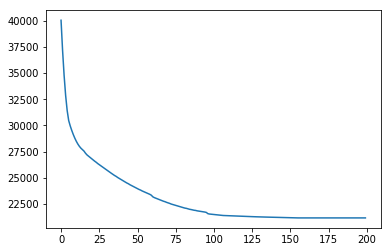

In [106]:
# 简化版测试算法
# 到后期，误差收敛到一定值
arr = np.zeros(200)
for i in range(200):
    arr[i] = test(retWetMat,i)
    print(arr[i])
arr.min()
errorFig = plt.figure()
errorAx = errorFig.add_subplot(111)
errorAx.plot(arr)
plt.show()

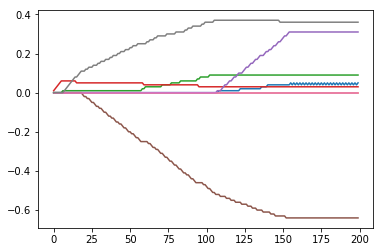

In [107]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(retWetMat)
plt.show()

In [110]:
# 使用更小的步长，解决震荡问题
retWetMat  = stageWise(xArr,yArr,0.005,1000)

[[ 0.  0.  0.  0.  0.  0.  0.  0.]]
[[ 0.     0.     0.     0.005  0.     0.     0.     0.   ]]
[[ 0.    0.    0.    0.01  0.    0.    0.    0.  ]]
[[ 0.     0.     0.     0.015  0.     0.     0.     0.   ]]
[[ 0.    0.    0.    0.02  0.    0.    0.    0.  ]]
[[ 0.     0.     0.     0.025  0.     0.     0.     0.   ]]
[[ 0.    0.    0.    0.03  0.    0.    0.    0.  ]]
[[ 0.     0.     0.     0.035  0.     0.     0.     0.   ]]
[[ 0.    0.    0.    0.04  0.    0.    0.    0.  ]]
[[ 0.     0.     0.     0.045  0.     0.     0.     0.   ]]
[[ 0.    0.    0.    0.05  0.    0.    0.    0.  ]]
[[ 0.     0.     0.     0.055  0.     0.     0.     0.   ]]
[[ 0.    0.    0.    0.06  0.    0.    0.    0.  ]]
[[ 0.     0.     0.     0.065  0.     0.     0.     0.   ]]
[[ 0.     0.     0.005  0.065  0.     0.     0.     0.   ]]
[[ 0.     0.     0.005  0.065  0.     0.     0.     0.005]]
[[ 0.     0.     0.005  0.065  0.     0.     0.     0.01 ]]
[[ 0.     0.     0.005  0.065  0.     0.     0.     

[[ 0.     0.     0.055  0.035  0.    -0.355  0.     0.305]]
[[ 0.     0.     0.055  0.035  0.    -0.36   0.     0.305]]
[[ 0.     0.     0.055  0.035  0.    -0.36   0.     0.31 ]]
[[ 0.     0.     0.055  0.035  0.    -0.365  0.     0.31 ]]
[[ 0.     0.     0.055  0.035  0.    -0.37   0.     0.31 ]]
[[ 0.     0.     0.06   0.035  0.    -0.37   0.     0.31 ]]
[[ 0.     0.     0.06   0.035  0.    -0.375  0.     0.31 ]]
[[ 0.     0.     0.06   0.035  0.    -0.38   0.     0.31 ]]
[[ 0.     0.     0.06   0.035  0.    -0.38   0.     0.315]]
[[ 0.     0.     0.06   0.035  0.    -0.385  0.     0.315]]
[[ 0.     0.     0.06   0.035  0.    -0.39   0.     0.315]]
[[ 0.     0.     0.065  0.035  0.    -0.39   0.     0.315]]
[[ 0.     0.     0.065  0.035  0.    -0.395  0.     0.315]]
[[ 0.     0.     0.065  0.035  0.    -0.4    0.     0.315]]
[[ 0.     0.     0.065  0.035  0.    -0.4    0.     0.32 ]]
[[ 0.     0.     0.065  0.035  0.    -0.405  0.     0.32 ]]
[[ 0.     0.     0.065  0.035  0.    -0.

[[ 0.025  0.     0.1    0.025  0.28  -0.625 -0.005  0.365]]
[[ 0.025  0.     0.1    0.025  0.285 -0.625 -0.005  0.365]]
[[ 0.025  0.     0.1    0.025  0.285 -0.625 -0.01   0.365]]
[[ 0.025  0.     0.1    0.025  0.29  -0.625 -0.01   0.365]]
[[ 0.025  0.     0.1    0.025  0.295 -0.625 -0.01   0.365]]
[[ 0.025  0.     0.1    0.025  0.3   -0.625 -0.01   0.365]]
[[ 0.025  0.     0.1    0.025  0.305 -0.625 -0.01   0.365]]
[[ 0.025  0.     0.1    0.025  0.305 -0.63  -0.01   0.365]]
[[ 0.025  0.     0.1    0.025  0.31  -0.63  -0.01   0.365]]
[[ 0.025  0.     0.1    0.025  0.315 -0.63  -0.01   0.365]]
[[ 0.025  0.     0.1    0.025  0.315 -0.63  -0.01   0.36 ]]
[[ 0.025  0.     0.1    0.025  0.32  -0.63  -0.01   0.36 ]]
[[ 0.025  0.     0.1    0.025  0.325 -0.63  -0.01   0.36 ]]
[[ 0.025  0.     0.1    0.025  0.33  -0.63  -0.01   0.36 ]]
[[ 0.025  0.     0.1    0.025  0.33  -0.635 -0.01   0.36 ]]
[[ 0.025  0.     0.1    0.025  0.335 -0.635 -0.01   0.36 ]]
[[ 0.025  0.     0.1    0.025  0.34  -0.

[[ 0.035  0.     0.105  0.025  0.9   -0.75  -0.04   0.3  ]]
[[ 0.035  0.     0.105  0.025  0.9   -0.755 -0.04   0.3  ]]
[[ 0.035  0.     0.105  0.025  0.905 -0.755 -0.04   0.3  ]]
[[ 0.035  0.     0.105  0.025  0.91  -0.755 -0.04   0.3  ]]
[[ 0.04   0.     0.105  0.025  0.91  -0.755 -0.04   0.3  ]]
[[ 0.04   0.     0.105  0.025  0.915 -0.755 -0.04   0.3  ]]
[[ 0.04   0.     0.105  0.025  0.915 -0.755 -0.04   0.295]]
[[ 0.04   0.     0.105  0.025  0.92  -0.755 -0.04   0.295]]
[[ 0.04   0.     0.105  0.025  0.925 -0.755 -0.04   0.295]]
[[ 0.04   0.     0.105  0.025  0.93  -0.755 -0.04   0.295]]
[[ 0.04   0.     0.105  0.025  0.93  -0.76  -0.04   0.295]]
[[ 0.04   0.     0.105  0.025  0.935 -0.76  -0.04   0.295]]
[[ 0.04   0.     0.105  0.025  0.94  -0.76  -0.04   0.295]]
[[ 0.04   0.     0.105  0.025  0.94  -0.765 -0.04   0.295]]
[[ 0.04   0.     0.105  0.025  0.945 -0.765 -0.04   0.295]]
[[ 0.04   0.     0.105  0.025  0.95  -0.765 -0.04   0.295]]
[[ 0.04   0.     0.105  0.025  0.95  -0.

[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.

[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]]
[[ 0.04   0.     0.105  0.025  1.295 -0.

41675.4162015
40059.6071764
38563.2035207
37186.2052344
35928.6123176
34790.4247702
33771.6425922
32872.2657837
32092.2943446
31431.728275
30890.5675747
30468.8122439
30166.4622826
29942.656075
29735.8040871
29539.7327092
29354.4419413
29179.9317835
29016.2022357
28863.253298
28721.0849703
28589.6972527
28469.0901451
28359.2636476
28260.2177601
28171.9524826
28080.448438
27973.6389546
27877.6100813
27792.361818
27717.8941647
27628.4962256
27535.4843664
27453.2531173
27381.8024782
27321.1324491
27233.8406155
27154.6263805
27086.1927556
27028.5397407
26965.9303968
26907.5611665
26848.7540281
26788.6575447
26732.8011748
26672.8399129
26615.2562898
26560.1082712
26500.7973949
26445.7266323
26389.4244901
26332.6264743
26280.0685721
26222.6123064
26168.327151
26115.6841286
26058.2503765
25987.0631481
25926.6565298
25876.1469932
25820.5536182
25768.3168284
25717.5366966
25663.5726537
25613.8487244
25561.9144691
25510.4632866
25463.2522177
25410.1638389
25361.2255168
25312.9503812
25262.284806

20652.1271921
20652.2227567
20652.1271921
20652.2227567
20652.1271921
20652.2227567
20652.1271921
20652.2227567
20652.1271921
20652.2227567
20652.1271921
20652.2227567
20652.1271921
20652.2227567
20652.1271921
20652.2227567
20652.1271921
20652.2227567
20652.1271921
20652.2227567
20652.1271921
20652.2227567
20652.1271921
20652.2227567
20652.1271921
20652.2227567
20652.1271921
20652.2227567
20652.1271921
20652.2227567
20652.1271921
20652.2227567
20652.1271921
20652.2227567
20652.1271921
20652.2227567
20652.1271921
20652.2227567
20652.1271921
20652.2227567
20652.1271921
20652.2227567
20652.1271921
20652.2227567
20652.1271921
20652.2227567
20652.1271921
20652.2227567
20652.1271921
20652.2227567
20652.1271921
20652.2227567
20652.1271921
20652.2227567
20652.1271921
20652.2227567
20652.1271921
20652.2227567
20652.1271921
20652.2227567
20652.1271921
20652.2227567
20652.1271921
20652.2227567
20652.1271921
20652.2227567
20652.1271921
20652.2227567
20652.1271921
20652.2227567
20652.1271921
20652.

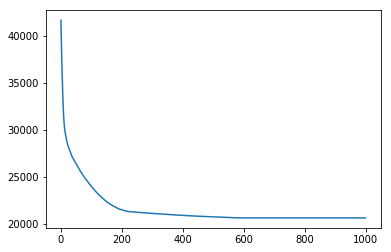

In [112]:
# 到后期，误差收敛到一定值
arr = np.zeros(1000)
for i in range(1000):
    arr[i] = test(retWetMat,i)
    print(arr[i])
arr.min()
errorFig = plt.figure()
errorAx = errorFig.add_subplot(111)
errorAx.plot(arr)
plt.show()

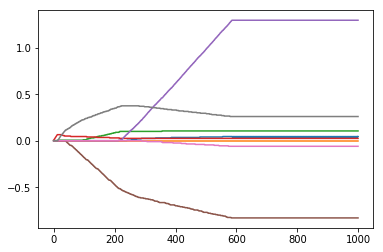

In [111]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(retWetMat)
plt.show()